In [1]:
from fastai.vision.all import *

In [23]:
def load_data(folder):
    path = untar_data(URLs.MNIST_SAMPLE)
    threes = [tensor(Image.open(o)) for o in (path / f"{folder}" / '3').ls().sorted()]
    sevens = [tensor(Image.open(o)) for o in (path / f"{folder}" / '7').ls().sorted()]
    threes_stacked = torch.stack(threes).float() / 255.0
    sevens_stacked = torch.stack(sevens).float() / 255.0
    x = torch.cat([threes_stacked, sevens_stacked]).view(-1, 28*28)
    y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(-1)
    dset = list(zip(x, y))
    return DataLoader(dset, batch_size=256, shuffle=True)

def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

def linear1(xb):
    return xb@weights + bias

def mnist_loss(yhat, yb):
    yhat = yhat.sigmoid()
    return torch.where((yb==1), 1-yhat, yhat).mean()

def calc_grad(xb, yb, model):
    yhat = model(xb)
    loss = mnist_loss(yhat, yb)
    loss.backward()
     
def train_epoch(train_dl):
    for xb, yb in train_dl:
        calc_grad(xb, yb, linear1)
        for p in params:
            p.data -= p.grad * lr
            p.grad = None

def valid_acc(yhat, yb):
    yhat = yhat.sigmoid()
    return ((yhat > 0.5) == yb).float().mean()
    
def valid_epoch(valid_dl):
    accs = [valid_acc(linear1(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(),4)



In [24]:
train_dl = load_data('train')
valid_dl = load_data('valid')

In [30]:
lr = 1.0
weights = init_params((28*28,1))
bias = init_params(1)
params = weights, bias
for _ in range(20):
    train_epoch(train_dl)
    print(valid_epoch(valid_dl), end=' ')

0.8589 0.9377 0.953 0.9606 0.9627 0.9681 0.9697 0.9706 0.9705 0.9715 0.973 0.975 0.9765 0.977 0.9779 0.9774 0.9778 0.9789 0.9794 0.9789 

In [46]:
store_attr??

In [49]:
class BasicOptim:
    def __init__(self, lr, params):
        self.lr = lr
        self.params = params
    def step(self):
        for p in self.params:
            p.data -= p.grad * self.lr
    def zero_grad(self):
        for p in self.params:
            p.grad = None

def train_epoch2(train_dl):
    for xb, yb in train_dl:
        calc_grad(xb, yb, linear1)
        opt.step()
        opt.zero_grad()
        
def train_model(epochs):
    for epoch in range(epochs):
        train_epoch2(train_dl)
        print(valid_epoch(valid_dl), end=' ')
        

In [51]:
lr = 1.0
weights = init_params((28*28,1))
bias = init_params(1)
params = weights, bias
opt = BasicOptim(lr, params)
train_model(20)

0.8759 0.9322 0.9427 0.9514 0.9548 0.9617 0.9627 0.9647 0.9651 0.9671 0.9676 0.9691 0.9686 0.9721 0.9725 0.9726 0.9735 0.974 0.9739 0.9755 

In [73]:
simple_model = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)
dls = DataLoaders(train_dl, valid_dl)
learn = Learner(dls, simple_model, loss_func=mnist_loss, opt_func=SGD, metrics=valid_acc)

(0.33113112449646, 1.0964782238006592)

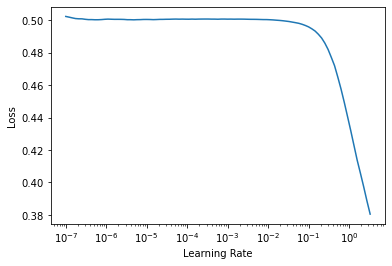

In [74]:
minval, steep = learn.lr_find()
minval, steep

In [75]:
learn.fit(40,0.3)

epoch,train_loss,valid_loss,valid_acc,time
0,0.099426,0.043763,0.970069,00:00
1,0.051667,0.034144,0.972522,00:00
2,0.035553,0.030918,0.975466,00:00
3,0.027997,0.027687,0.977920,00:00
4,0.024237,0.025859,0.979882,00:00
5,0.021762,0.025450,0.977920,00:00
6,0.019627,0.023732,0.979392,00:00
7,0.018507,0.023053,0.980373,00:00
8,0.018085,0.022623,0.980373,00:00
9,0.017351,0.021818,0.981354,00:00


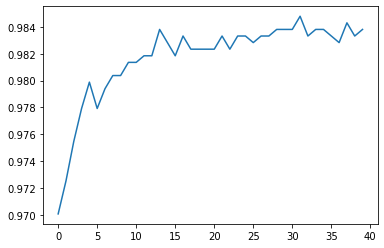

In [76]:
plt.plot(tensor(learn.recorder.values)[:,2]);